<a href="https://colab.research.google.com/github/newguy7/DataScienceProjects/blob/main/pretrained_yolo_image_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import argparse
import numpy as np

In [ ]:
!python yolo_opencv.py --image dog.jpg --config yolov3.cfg --weights yolov3.weights --classes yolov3.txt


python3: can't open file '/content/yolo_opencv.py': [Errno 2] No such file or directory


In [ ]:
# # handle command line arguments
# ap = argparse.ArgumentParser()
# ap.add_argument('-i', '--image',required=True,
#                 help = 'dog.jpg')
# ap.add_argument('-c', '--config', required=True,
#                 help = 'yolov3.cfg')
# ap.add_argument('-w', '--weights', required=True,
#                 help = 'yolov3.weights')
# ap.add_argument('-cl', '--classes', required=True,
#                 help = 'yolov3.txt')


_StoreAction(option_strings=['-cl', '--classes'], dest='classes', nargs=None, const=None, default=None, type=None, choices=None, required=True, help='yolov3.txt', metavar=None)

In [ ]:
# args = ap.parse_args()

Preparing input

In [ ]:
#function to get output layer names in the architecture
def get_output_layers(net):

    layer_names = net.getLayerNames()
    try:
        output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    except:
        output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return output_layers

# function to draw bounding box on the detected object with class name
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = str(classes[class_id])

    color = COLORS[class_id]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


In [ ]:
# read input image
image = cv2.imread('dog.jpg')

# get h and w to calculate bounding box
Width = image.shape[1]
Height = image.shape[0]

# scale helps image to convert to blob
# constant value
# same value(0.00392) for yolo
scale = 0.00392

# read class names from text file
classes = None
with open('yolov3.txt', 'r') as f:
  classes = [line.strip() for line in f.readlines()]

# generate different colors for different classes
COLORS = np.random.uniform(0,255, size=(len(classes),3))

# read pre-trained model and config title
# and create the network
# cv2.dnn deep neural networks
net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')

# create input blob
# prepare the input image to run through the deep neural network
# type of object how image are stored
# blob is object storage object
# 416,416 = target image size
# (0,0,0) mean
blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

# set input blob for the network
net.setInput(blob)




Output layer and bounding box

Running inference

In [ ]:
# run inference through the network and gather predictions from output layers
outs = net.forward(get_output_layers(net))

# initialization
class_ids = []
confidences = []
boxes = []
conf_threshold = 0.5
nms_threshold = 0.4

# for each detection from each output layer
# get the confidence, class id, bounding box params
# and ignore weak detections (confidence < 0.5)
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * Width)
            center_y = int(detection[1] * Height)
            w = int(detection[2] * Width)
            h = int(detection[3] * Height)
            x = center_x - w / 2
            y = center_y - h / 2
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([x, y, w, h])

Non-max suppression

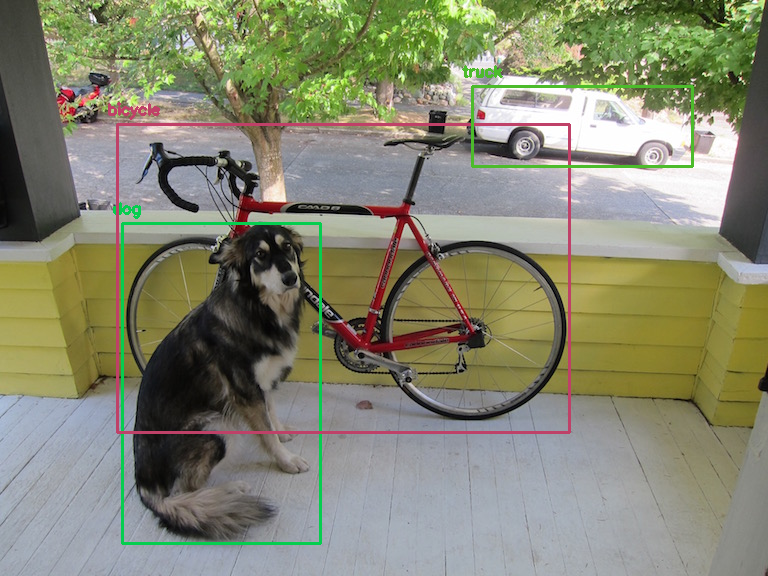

In [ ]:
from google.colab.patches import cv2_imshow
# apply non-max suppression
indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

# go through the detections remaining
# after nms and draw bounding box
for i in indices:
    try:
        box = boxes[i]
    except:
        i = i[0]
        box = boxes[i]

    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    draw_bounding_box(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))

# display output image
cv2_imshow(image)

# wait until any key is pressed
cv2.waitKey()

 # save output image to disk
cv2.imwrite("object-detection.jpg", image)

# release resources
cv2.destroyAllWindows()